# AGH Modelling of Physical Systems Lab 3 (2025 March 18th)
Jakub Kubicki  (jakubkubicki@student.agh.edu.pl)

**1. advection PDE**

Let's introduce a few symbols:   
* ${\color{red}t}$: time   
* ${\color{blue}x}$: physical coordinate (e.g., distance or altitude)   
* ${\color{green}\psi}({\color{blue}x})$: scalar field (e.g., pollutant concentration)   
* ${\color{brown}u}$: carrier velocity field (e.g., wind)   

Transport of $\color{green}\psi$ due to advection by $\color{brown}u$ can be modelled with the advection equation:
$$ \partial_{\color{red} t} {\color{green}\psi} + \partial_{\color{blue}x} \left({\color{brown}u} {\color{green}\psi}\right) = 0 $$

For the special case of $\partial_{\color{blue}x} {\color{brown}u}=0$, an analytical solution describing translation of the signal is readily available:
$$ {\color{green}\psi}({\color{blue}x}, {\color{red}t})=\psi_0({\color{blue}x} - {\color{brown}u}{\color{red}t})$$
where $\psi_0({\color{blue}x})={\color{green}\psi}({\color{blue}x}, 0)$.

Let's depict the problem using NumPy and matplotlib:

In [57]:
import numpy as np
from matplotlib import pyplot

In [58]:
class Psi_0:
    def __init__(self):
        self.x0 = 5
        self.a = 1
        self.sigma = 25
    def __call__(self, x):
        return self.a * np.exp(-(x-self.x0)**2 / 2 / self.sigma**2)

In [59]:
psi_0 = Psi_0()
nx = 64 #sampling of the curve
x, dx = np.linspace(-100, 300, nx, endpoint=False, retstep=True)
u = 2
t_max = 50

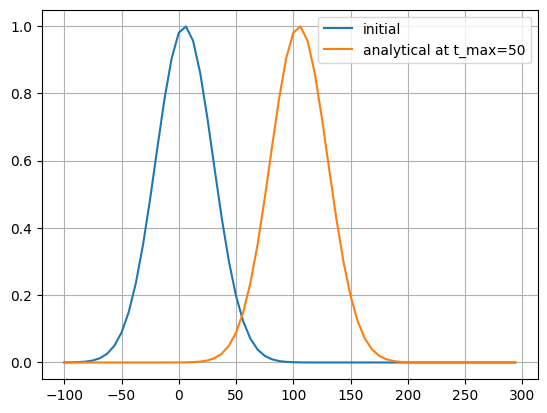

In [60]:
pyplot.plot(x, psi_0(x), label='initial')
pyplot.plot(x, psi_0(x - u * t_max), label=f'analytical at {t_max=}')
pyplot.legend()
pyplot.grid()

**2. overview of applications**

* **computational fluid dynamics**: Navier-Stokes momentum equation ($\psi$: fluid momentum)
* **fluid thermodynamics**: energy conservation ($\psi$: thermal energy)
* **atmospheric modelling incl. weather prediction**: mass conservation ($\psi$: humidity, rain, pollutants, ...)
* **derivative pricing in financial mathematics**: Black-Scholes equation ($\psi$: discounted value of a derivative instrument)
* ...

**3. simple numerical solution using the "upwind" scheme coded in Python**

For cases where the velocity varies in space (and for many other more complex cases), numerical integration is the only way of solving the advection PDE. Among numerous numerical schemes for solving it, let's look at the basic [**upwind**](https://en.wikipedia.org/wiki/Upwind_scheme) solver:

Let's consider the following discretisation of the problem:   
* ${\color{red}n} = \frac{\color{red}t}{\Delta t} \in 0, 1, \ldots$   
* ${\color{blue}i} = \frac{\color{blue}x}{\Delta x} \in 0, 1, \ldots$   
* ${\color{brown}C} = {\color{brown}u}\frac{\Delta t}{\Delta x}$ (so called Courant number)   
* ${\color{green}\psi}_{\color{blue}i}^{\color{red}n}$: scalar field at "grid cell" $\color{blue}i$ in space at time "level" ${\color{red}n}$   

The explicit (forward-in-time) upwind scheme is defined as:
$$
  {\color{green}\psi}^{{\color{red}n}+1}_{\color{blue}i} = {\color{green}\psi}^{\color{red}n}_{\color{blue}i} - \left[F\left({\color{green}\psi}^{\color{red}n}_{\color{blue}i},  {\color{green}\psi}^{\color{red}n}_{{\color{blue}i}+1}, {\color{brown}C}\right)-F\left({\color{green}\psi}^{\color{red}n}_{{\color{blue}i}-1},{\color{green}\psi}^{\color{red}n}_{\color{blue}i}, {\color{brown}C}\right)\right]
$$
$$F(\psi_L, \psi_R, C)=\frac{C+|C|}{2}\psi_L + \frac{C-|C|}{2}\psi_R$$

**4. upwind algorithm coded in Python/NumPy: functions and a useful structure**

In [61]:
class One:
  def __radd__(self, o):
    return slice(o.start+1, o.stop+1)
  def __rsub__(self, o):
    return slice(o.start-1, o.stop-1)

**5. upwind algorithm coded in Python/NumPy: data/objects**

In [62]:
def F(left, right, C):
  return .5 * (C + abs(C)) * left + .5 * (C - abs(C)) * right


**6. upwind algorithm coded in Python/NumPy: time-stepping loop**

In [63]:
# i is type of slice(a,b,c) a:b:c (avoiding loops and spedd u)
one = One()
i = slice(1,nx-2)
psi = psi_0(x)
nt = 50
dt = t_max/nt
C = u*dt/dx
for _ in range(nt):
    psi[i] = psi[i] - (F(psi[i],psi[i+one],C) - F(psi[i-one],psi[i],C))

**7. comparing analytic and numerical solutions**

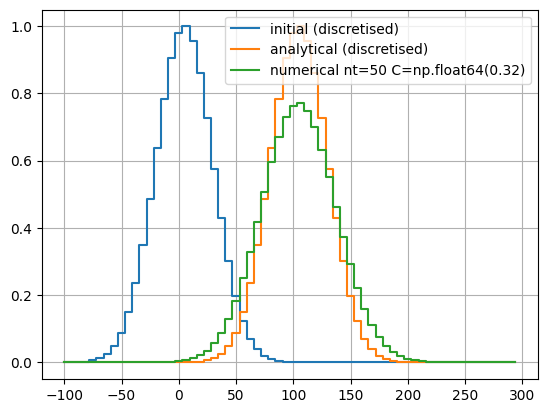

In [64]:
pyplot.step(x, psi_0(x), label='initial (discretised)', where='mid')
pyplot.step(x, psi_0(x-u*t_max), label='analytical (discretised)', where='mid')
pyplot.step(x, psi, label=f'numerical {nt=} {C=}', where='mid')
pyplot.legend()
pyplot.grid()

### RMSE calculation

The goal of the further analysis is to show how Root Mean Squared Error changes with changing time step (in the same time with keeping Courant number unchaged).

Therefore number of time steps is changed by the certain step (in this situation the step of number of time steps is equal to 3) and in the same time number of distance steps is being changed (by the constant number 2 multiplied by number of time steps).

It is made in order to keep Courant number (which depends on $\frac{\Delta t}{\Delta x}$) constant (in this situation it is equal to 0.5).

In [65]:
def RMSE(nt, nx):
  x, dx = np.linspace(-100, 300, nx, endpoint=False, retstep=True)
  one = One()
  i = slice(1,nx-2)
  psi = psi_0(x)
  dt = t_max/nt
  C = u*dt/dx
  print(f'Courant number: {C}')
  for _ in range(nt):
      psi[i] = psi[i] - (F(psi[i],psi[i+one],C) - F(psi[i-one],psi[i],C))
  psi_analytical = psi_0(x - u * t_max)
  return np.sqrt(np.mean((psi - psi_analytical)**2))


Courant number: 0.5
Courant number: 0.5
Courant number: 0.5
Courant number: 0.5
Courant number: 0.5
Courant number: 0.5
Courant number: 0.5
Courant number: 0.5
Courant number: 0.5
Courant number: 0.5
Courant number: 0.5
Courant number: 0.5
Courant number: 0.5
Courant number: 0.5
Courant number: 0.5
Courant number: 0.5
Courant number: 0.5
Courant number: 0.5
Courant number: 0.5


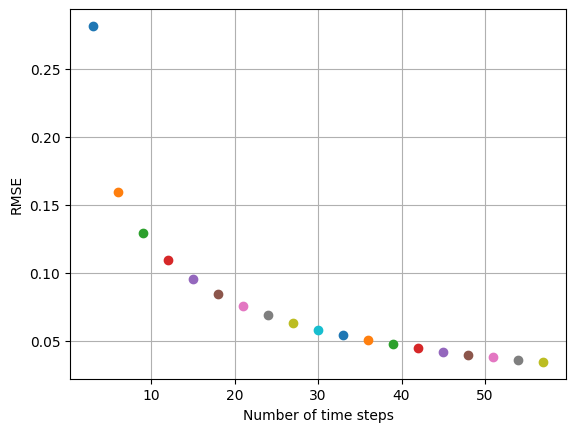

In [66]:
nx_nt_const = 2
nt_old = 3


for i in range(1, 20):
  nt = i * nt_old
  rmse = RMSE(nt, nx_nt_const*nt)
  pyplot.plot(nt , rmse , 'o', label='RMSE points')  # 'o' means circle markers

pyplot.xlabel('Number of time steps')
pyplot.ylabel('RMSE')
pyplot.grid()
pyplot.show()



# results

On the plot we can see that the root mean squared error decreases logarithmically with the number of time steps.

It is important to point out that Courant number stays unchaged (equals to 0.5) due to changing the number of distance steps in the same time.